## 1. Import library

In [1]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
!pip install wandb
!pip install torchmetrics

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import json
import re
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils import to_categorical
from keras import regularizers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier

from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Flatten, Dense, Dropout

pd.set_option('display.max_colwidth', 200)

In [4]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: thanh-bv. Use `wandb login --relogin` to force relogin


True

Read data

In [5]:
news_text = []
news_label = []

with open('./News_Category_Dataset_v3.json') as file:
    for news in file:
        j_news = json.loads(news)
        news_label.append(j_news['category'])
        news_text.append(j_news['headline'] + ' ' + j_news['short_description'])

In [6]:
news_df = pd.DataFrame(data=list(zip(news_text, news_label)), columns=['text', 'cat'])

In [7]:
news_df.head()

,text,cat
0,Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID Boosters Health experts said it is too early to predict whether demand would match up with the 171 million doses of the new boos...,U.S. NEWS
1,"American Airlines Flyer Charged, Banned For Life After Punching Flight Attendant On Video He was subdued by passengers and crew when he fled to the back of the aircraft after the confrontation, ac...",U.S. NEWS
2,"23 Of The Funniest Tweets About Cats And Dogs This Week (Sept. 17-23) ""Until you have a dog you don't understand what could be eaten.""",COMEDY
3,"The Funniest Tweets From Parents This Week (Sept. 17-23) ""Accidentally put grown-up toothpaste on my toddler’s toothbrush and he screamed like I was cleaning his teeth with a Carolina Reaper dippe...",PARENTING
4,Woman Who Called Cops On Black Bird-Watcher Loses Lawsuit Against Ex-Employer Amy Cooper accused investment firm Franklin Templeton of unfairly firing her and branding her a racist after video of ...,U.S. NEWS


##2. Data cleaning and preprocessing

### 2.1 Removing similar categories

In [8]:
# it looks like THE WORLDPOST and WORLDPOST are similar categories, so lets convert THE WORLDPOST to WORLDPOST
news_df.loc[news_df["cat"] == "THE WORLDPOST", "cat"] = "WORLDPOST"

In [9]:
news_df.loc[news_df['cat'] == 'CULTURE & ARTS', 'cat'] = 'ARTS & CULTURE'

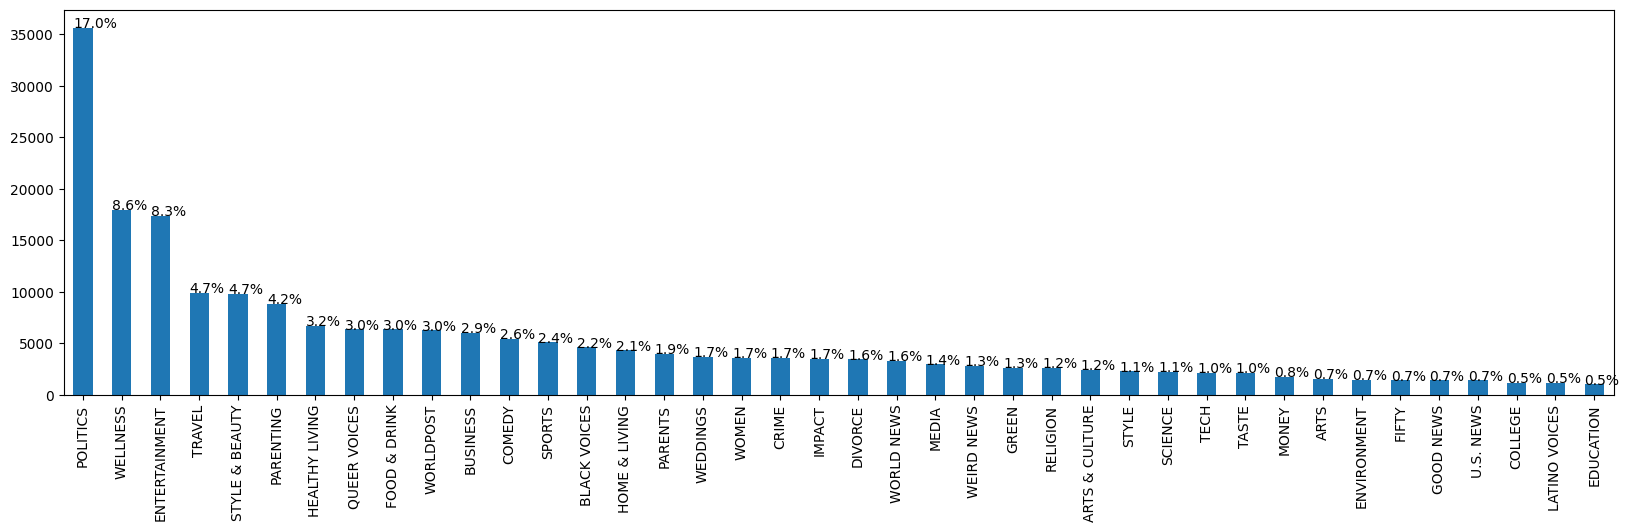

In [10]:
news_count = news_df['cat'].value_counts()
news_percent = [len(news_df[news_df['cat'] == news_cat]) / len(news_df) * 100 for news_cat in news_count.index]

ax = news_count.plot(kind='bar', figsize=(20, 5))
for idx, p in enumerate(ax.patches):
    h = p.get_height()
    x, y = p.get_xy()
    ax.annotate('{:.1f}%'.format(news_percent[idx]), (x, y + h + 0.01))

### 2.2 Clean Text

In [11]:
# lets do some text preprocessing
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

In [12]:
def clean_text(text):

    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # remove BAD_SYMBOLS_RE symbols in text
    text = ' '.join(word for word in text.split(' ') if word not in STOPWORDS) # remove stopwords from text

    return text

In [13]:
news_df['text'] = news_df['text'].apply(clean_text)

### 2.3. Tokenization

In [14]:
# tokenizing is the process of splitting the text into tokens. It create word_index for each token
# which can be used to convert text sequence into integer sequence
max_words = 10000
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(news_df['text'])
sequence = tok.texts_to_sequences(news_df['text'])

In [15]:
# each of text in the news_df is converted to a sequence of words.
news_df['text'][0], len(news_df['text'][0].split())

('4 million americans roll sleeves omicrontargeted covid boosters health experts said early predict whether demand would match 171 million doses new boosters us ordered fall',
 25)

In [16]:
word_index = tok.word_index
print(f'Found { len(word_index) } unique tokens.')

Found 115317 unique tokens.


In [17]:
news_df['word_seq'] = sequence
news_df['num_words'] = news_df['word_seq'].str.len()

In [18]:
# articles having few words are not providing sufficient information for classifying it into any group.
# also the number of such samples is less, so we can just not consider them
news_df = news_df[news_df['num_words'] > 3]

In [19]:
news_df.head()

,text,cat,word_seq,num_words
0,4 million americans roll sleeves omicrontargeted covid boosters health experts said early predict whether demand would match 171 million doses new boosters us ordered fall,U.S. NEWS,"[284, 169, 163, 2103, 6445, 38, 765, 15, 435, 4284, 197, 1848, 22, 2047, 169, 1, 3, 3071, 292]",19
1,american airlines flyer charged banned life punching flight attendant video subdued passengers crew fled back aircraft confrontation according us attorneys office los angeles,U.S. NEWS,"[81, 1406, 1280, 2942, 12, 9773, 946, 5908, 19, 2669, 3086, 6638, 35, 6549, 8877, 257, 3, 4723, 332, 1073, 1178]",21
2,23 funniest tweets cats dogs week sept 1723 dog dont understand could eaten,COMEDY,"[2148, 1614, 624, 2284, 903, 29, 3977, 477, 14, 566, 23, 6639]",12
3,funniest tweets parents week sept 1723 accidentally put grownup toothpaste toddlers toothbrush screamed like cleaning teeth carolina reaper dipped tabasco sauce,PARENTING,"[1614, 624, 90, 29, 3977, 3951, 201, 7709, 2972, 7, 2383, 3630, 1099, 2858]",14
4,woman called cops black birdwatcher loses lawsuit exemployer amy cooper accused investment firm franklin templeton unfairly firing branding racist video central park encounter went viral,U.S. NEWS,"[113, 249, 1123, 76, 2721, 1224, 1773, 3566, 599, 2556, 2824, 6123, 3611, 8144, 1158, 19, 1416, 757, 3612, 501, 1450]",21


### 2.4. Preprocessing for Deep Learning

In [20]:
# our model expects the lenght of all sequence to be same. Now the lenght of the sequences are different corresponding
# to the length of the actual text. We can generalize it to a specific length of 60 by padding.
max_len = 30
data = pad_sequences(news_df['word_seq'], maxlen=max_len)

In [21]:
data[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        284,  169,  163, 2103, 6445,   38,  765,   15,  435, 4284,  197,
       1848,   22, 2047,  169,    1,    3, 3071,  292])

In [22]:
# one hot encode the labels
encoder = LabelEncoder()
encoder.fit(news_df['cat'])
labels = encoder.transform(news_df['cat'])
n_classes = max(labels) + 1
labels = to_categorical(labels, n_classes)

In [23]:
encoder.inverse_transform(np.asarray(range(40)))

array(['ARTS', 'ARTS & CULTURE', 'BLACK VOICES', 'BUSINESS', 'COLLEGE',
       'COMEDY', 'CRIME', 'DIVORCE', 'EDUCATION', 'ENTERTAINMENT',
       'ENVIRONMENT', 'FIFTY', 'FOOD & DRINK', 'GOOD NEWS', 'GREEN',
       'HEALTHY LIVING', 'HOME & LIVING', 'IMPACT', 'LATINO VOICES',
       'MEDIA', 'MONEY', 'PARENTING', 'PARENTS', 'POLITICS',
       'QUEER VOICES', 'RELIGION', 'SCIENCE', 'SPORTS', 'STYLE',
       'STYLE & BEAUTY', 'TASTE', 'TECH', 'TRAVEL', 'U.S. NEWS',
       'WEDDINGS', 'WEIRD NEWS', 'WELLNESS', 'WOMEN', 'WORLD NEWS',
       'WORLDPOST'], dtype=object)

### 2.5 Spliting the data

In [24]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.25, random_state=20)

In [25]:
x_train.shape, x_test.shape

((154674, 30), (51558, 30))

In [26]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=20)

In [27]:
x_train.shape, x_val.shape

((123739, 30), (30935, 30))

##3. Util

In [28]:
from torchmetrics.functional.classification import multiclass_precision, multiclass_accuracy, multiclass_recall, multiclass_f1_score, multiclass_auroc
import torch

C:\Users\DELL\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Hyperparameters


In [29]:
METRICS = [tf.keras.metrics.CategoricalAccuracy()]
BATCH_SIZE = 128
NUM_EPOCHS = 15
NUM_CLASSES = 40

In [30]:
def log(history, epochs):
  wandb.init(project="News Classification")
  acc = history.history['categorical_accuracy']
  val_acc = history.history['val_categorical_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  for e in range(epochs):
    # Logging with WnB
    wandb.log({"train_loss": loss[e],
               "train_accuracy": acc[e],
               "val_loss": val_loss[e],
               "val_accuracy": val_acc[e]
               })

In [31]:
def train(model, train_data, val_data, loss, optimizer, metrics, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, isGlove=False, embedding_dim=None, embedding_matrix=None):
  if isGlove:
    model.layers[0].set_weights([embedding_matrix])
    model.layers[0].trainable = False
  model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
  X_train, Y_train = train_data
  history = model.fit(
    x = X_train,
    y = Y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = val_data
  )
  log(history, epochs)

In [32]:
def test(model, x_test, y_test, n_classes=NUM_CLASSES):
  y_pred = model.predict(x_test, batch_size=BATCH_SIZE)
  y_pred = torch.argmax(torch.Tensor(y_pred), dim = 1)
  y_test = torch.argmax(torch.Tensor(y_test), dim = 1)

  print("For each class: ")
  print("Accuracy: ", multiclass_accuracy(y_pred, y_test, num_classes=n_classes, average=None))
  print("Precision: ", multiclass_precision(y_pred, y_test, num_classes=n_classes, average=None))
  print("Recall: ", multiclass_recall(y_pred, y_test, num_classes=n_classes, average=None))
  print("F1-score: ", multiclass_f1_score(y_pred, y_test, num_classes=n_classes, average=None))
  for a in ['micro', 'macro', 'weighted']:
    print("Type: ", a)
    print("Accuracy: ", multiclass_accuracy(y_pred, y_test, num_classes=n_classes, average=a))
    print("Precision: ", multiclass_precision(y_pred, y_test, num_classes=n_classes, average=a))
    print("Recall: ", multiclass_recall(y_pred, y_test, num_classes=n_classes, average=a))
    print("F1-score: ", multiclass_f1_score(y_pred, y_test, num_classes=n_classes, average=a))

In [33]:
class FocalLoss(tf.keras.losses.Loss):
  def __init__(self, gamma=2.0):
    super().__init__()
    self.gamma = gamma
  def call(self, y_true, y_pred):
    cce = tf.keras.losses.CategoricalCrossentropy()(y_true, y_pred)
    return 0.25*tf.math.pow(1-tf.math.exp(cce), self.gamma) * cce

## 4. Model



### 4.1 Basic ANN Model

In [34]:
def ANNModel(input_dim = max_words, output_dim=64, input_length = max_len, n_classes = 40):
  model = Sequential()
  model.add(Embedding(input_dim, output_dim, input_length= input_length))
  model.add(Flatten())
  model.add(Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.01)))
  model.add(Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.01)))
  model.add(Dense(n_classes, activation='softmax'))
  return model

### 4.2 ANNModel with Dropout

In [35]:
def ANNDropout(input_dim = max_words, output_dim=64, input_length = max_len, dropout_rate = 0.3, n_classes=40):
  model = Sequential()
  model.add(Embedding(input_dim, output_dim, input_length=input_length))
  model.add(Flatten())
  model.add(Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.01)))
  model.add(Dropout(dropout_rate))
  model.add(Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.01)))
  model.add(Dense(n_classes, activation='softmax'))
  return model

### 4.3. ANN with more dropout layer

In [36]:
def ANNDropout2(input_dim = max_words,output_dim =64, input_length = max_len, dropout_rate = 0.3, n_classes=40):
  model = Sequential()
  model.add(Embedding(input_dim, output_dim, input_length=input_length))
  model.add(Flatten())
  model.add(Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.01)))
  model.add(Dropout(dropout_rate))
  model.add(Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.01)))
  model.add(Dropout(dropout_rate))
  model.add(Dense(n_classes, activation='softmax'))
  return model

### Another way of Embedding

GloVe word embedding

In [37]:
# lets now try using pretrained word embedding - GloVe word embedding
# !curl -LO http://nlp.stanford.edu/data/glove.6B.zip

In [38]:
# !unzip glove.6B.zip

In [39]:
# embeddings_index = {}

# with open("glove.6B.100d.txt", "r") as file:
#     for line in file:
#         values = line.split()
#         word = values[0]
#         coeffs = np.asarray(values[1:], dtype='float32')
#         embeddings_index[word] = coeffs

In [40]:
# print(f"there are {len(embeddings_index)} tokens.")

In [41]:
# embedding_dim = 100

# embedding_matrix = np.zeros((max_words, embedding_dim))
# for word, i in word_index.items():
#     if i < max_words:
#         embedding_vector = embeddings_index.get(word)
#         if embedding_vector is not None:
#             embedding_matrix[i] = embedding_vector

## 5. Training and test

### 5.1 Imbalance data

In [42]:
train_data = (x_train, y_train)
val_data = (x_val, y_val)
optimizer = 'Adam'
losses = [tf.keras.losses.CategoricalCrossentropy(), FocalLoss()]
for loss in losses:
  models = [ANNModel(), ANNDropout(), ANNDropout2()]
  for model in models:
    train(model, train_data, val_data, loss, optimizer, METRICS, epochs=10)
    test(model, x_test, y_test)

# for loss in losses:
#   modelsGloVe = [ANNModel(output_dim=embedding_dim), ANNDropout(output_dim=embedding_dim), ANNDropout2(output_dim=embedding_dim)]
#     train(model, train_data, val_data, loss, optimizer, METRICS, isGlove=True, embedding_dim=embedding_dim, embedding_matrix=embedding_matrix)
#     test(model, x_test, y_test)

Epoch 1/10
967/967 [==============================] - 11s 10ms/step - loss: 2.9099 - categorical_accuracy: 0.2971 - val_loss: 2.5583 - val_categorical_accuracy: 0.3615
Epoch 2/10
967/967 [==============================] - 9s 9ms/step - loss: 2.4643 - categorical_accuracy: 0.3782 - val_loss: 2.4502 - val_categorical_accuracy: 0.3864
Epoch 3/10
967/967 [==============================] - 8s 9ms/step - loss: 2.3045 - categorical_accuracy: 0.4224 - val_loss: 2.3190 - val_categorical_accuracy: 0.4264
Epoch 4/10
967/967 [==============================] - 9s 9ms/step - loss: 2.1733 - categorical_accuracy: 0.4558 - val_loss: 2.2622 - val_categorical_accuracy: 0.4398
Epoch 5/10
967/967 [==============================] - 9s 10ms/step - loss: 2.0781 - categorical_accuracy: 0.4795 - val_loss: 2.2608 - val_categorical_accuracy: 0.4466
Epoch 6/10
967/967 [==============================] - 14s 15ms/step - loss: 1.9729 - categorical_accuracy: 0.5056 - val_loss: 2.3159 - val_categorical_accuracy: 0.4437

403/403 [==============================] - 1s 2ms/step
For each class: 
Accuracy:  tensor([0.0000, 0.0000, 0.0121, 0.2324, 0.0000, 0.2704, 0.1879, 0.4610, 0.0000,
        0.6076, 0.0084, 0.0000, 0.5310, 0.0000, 0.0051, 0.1907, 0.2253, 0.0732,
        0.0000, 0.0213, 0.0090, 0.4578, 0.0667, 0.7563, 0.4861, 0.0405, 0.0000,
        0.2271, 0.0349, 0.6068, 0.0534, 0.0000, 0.4890, 0.0000, 0.5807, 0.0062,
        0.5481, 0.1244, 0.0000, 0.3845])
Precision:  tensor([0.0000, 0.0000, 0.0513, 0.1816, 0.0000, 0.2630, 0.1822, 0.7325, 0.0000,
        0.4116, 0.0375, 0.0000, 0.3804, 0.0000, 0.0857, 0.1619, 0.2821, 0.0862,
        0.0000, 0.1481, 0.1290, 0.3249, 0.0957, 0.6240, 0.4710, 0.0695, 0.0000,
        0.1702, 0.0614, 0.5884, 0.1250, 0.0000, 0.3387, 0.0000, 0.6812, 0.0702,
        0.5183, 0.0469, 0.0000, 0.2962])
Recall:  tensor([0.0000, 0.0000, 0.0121, 0.2324, 0.0000, 0.2704, 0.1879, 0.4610, 0.0000,
        0.6076, 0.0084, 0.0000, 0.5310, 0.0000, 0.0051, 0.1907, 0.2253, 0.0732,
        0.0000

train_accuracy,▁▃▄▄▅▅▆▇▇█
train_loss,█▆▅▄▄▃▃▂▂▁
val_accuracy,▁▃▆▇██▇▆▅▄
val_loss,▄▃▂▁▁▂▃▄▆█
train_accuracy,0.63385
train_loss,1.50879
val_accuracy,0.40139
val_loss,2.93149


403/403 [==============================] - 2s 5ms/step
For each class: 
Accuracy:  tensor([0.0000, 0.0289, 0.0388, 0.3942, 0.0000, 0.1220, 0.2158, 0.5548, 0.0000,
        0.6731, 0.0111, 0.0000, 0.6764, 0.0000, 0.0690, 0.0789, 0.3643, 0.0413,
        0.0000, 0.0000, 0.0000, 0.5393, 0.0719, 0.7991, 0.6101, 0.0016, 0.0133,
        0.4884, 0.0019, 0.7236, 0.0375, 0.0056, 0.6562, 0.0000, 0.7038, 0.0556,
        0.6690, 0.1035, 0.0000, 0.5953])
Precision:  tensor([0.0000, 0.2099, 0.1948, 0.1928, 0.0000, 0.4618, 0.2325, 0.7958, 0.0000,
        0.4496, 0.1000, 0.0000, 0.5005, 0.0000, 0.1010, 0.1768, 0.4144, 0.0850,
        0.0000, 0.0000, 0.0000, 0.4047, 0.1462, 0.6350, 0.5407, 0.5000, 0.0667,
        0.3539, 0.1667, 0.6659, 0.1681, 0.1111, 0.4678, 0.0000, 0.6558, 0.0739,
        0.5369, 0.1224, 0.0000, 0.2692])
Recall:  tensor([0.0000, 0.0289, 0.0388, 0.3942, 0.0000, 0.1220, 0.2158, 0.5548, 0.0000,
        0.6731, 0.0111, 0.0000, 0.6764, 0.0000, 0.0690, 0.0789, 0.3643, 0.0413,
        0.0000

train_accuracy,▁▃▃▄▅▅▆▇▇█
train_loss,█▆▅▄▄▃▃▂▁▁
val_accuracy,▁▁▃▅▆▇███▇
val_loss,█▆▄▂▁▁▁▂▃▅
train_accuracy,0.58651
train_loss,1.69828
val_accuracy,0.46601
val_loss,2.46597


403/403 [==============================] - 2s 5ms/step
For each class: 
Accuracy:  tensor([0.0000, 0.0000, 0.0155, 0.3788, 0.0000, 0.0645, 0.2320, 0.5277, 0.0000,
        0.7058, 0.0111, 0.0000, 0.7092, 0.0000, 0.0303, 0.0802, 0.3058, 0.0543,
        0.0000, 0.0000, 0.0000, 0.5853, 0.0459, 0.8042, 0.6286, 0.0062, 0.0228,
        0.3868, 0.0155, 0.7534, 0.0020, 0.0037, 0.6212, 0.0000, 0.6458, 0.0448,
        0.6873, 0.0733, 0.0000, 0.5556])
Precision:  tensor([0.0000, 0.0000, 0.1047, 0.2279, 0.0000, 0.5390, 0.1756, 0.7023, 0.0000,
        0.4217, 0.0784, 0.0000, 0.4928, 0.0000, 0.1091, 0.1676, 0.4664, 0.0870,
        0.0000, 0.0000, 0.0000, 0.3665, 0.1384, 0.6218, 0.5853, 0.2353, 0.0870,
        0.3255, 0.5714, 0.6191, 0.3333, 0.0833, 0.4886, 0.0000, 0.7137, 0.0863,
        0.5204, 0.0949, 0.0000, 0.2833])
Recall:  tensor([0.0000, 0.0000, 0.0155, 0.3788, 0.0000, 0.0645, 0.2320, 0.5277, 0.0000,
        0.7058, 0.0111, 0.0000, 0.7092, 0.0000, 0.0303, 0.0802, 0.3058, 0.0543,
        0.0000

train_accuracy,▁▂▃▄▅▆▆▇▇█
train_loss,█▅▅▄▄▃▂▂▁▁
val_accuracy,▁▂▃▅▇█████
val_loss,█▆▄▂▁▁▁▂▃▅
train_accuracy,0.56742
train_loss,1.77057
val_accuracy,0.46585
val_loss,2.44859


403/403 [==============================] - 1s 2ms/step
For each class: 
Accuracy:  tensor([0.0229, 0.2959, 0.2997, 0.3197, 0.0638, 0.3481, 0.4223, 0.5706, 0.2091,
        0.6367, 0.2061, 0.0059, 0.6245, 0.0088, 0.1818, 0.2689, 0.5369, 0.1157,
        0.0034, 0.1467, 0.1955, 0.5455, 0.1908, 0.7810, 0.6058, 0.2897, 0.2258,
        0.4938, 0.2345, 0.7509, 0.0455, 0.2004, 0.6103, 0.0191, 0.6771, 0.1360,
        0.6713, 0.1919, 0.3214, 0.3995])
Precision:  tensor([0.4444, 0.2762, 0.2617, 0.3681, 0.3673, 0.3593, 0.3788, 0.6352, 0.3571,
        0.4990, 0.2741, 0.2857, 0.5253, 0.0789, 0.2842, 0.2971, 0.5761, 0.1922,
        0.5000, 0.4490, 0.3750, 0.4295, 0.2842, 0.6429, 0.5302, 0.3470, 0.3165,
        0.5024, 0.4321, 0.6753, 0.3194, 0.3702, 0.6183, 0.1186, 0.6640, 0.2100,
        0.5251, 0.2811, 0.3242, 0.4436])
Recall:  tensor([0.0229, 0.2959, 0.2997, 0.3197, 0.0638, 0.3481, 0.4223, 0.5706, 0.2091,
        0.6367, 0.2061, 0.0059, 0.6245, 0.0088, 0.1818, 0.2689, 0.5369, 0.1157,
        0.0034

train_accuracy,▁▄▅▅▆▆▇▇██
train_loss,█▂▁▁▁▁▁▁▁▁
val_accuracy,▁▆▇██▇▆▅▄▄
val_loss,█▃▂▁▁▂▂▃▅▅
train_accuracy,0.76605
train_loss,1.63598
val_accuracy,0.50561
val_loss,21.90126


403/403 [==============================] - 1s 2ms/step
For each class: 
Accuracy:  tensor([0.0000, 0.1939, 0.2351, 0.3365, 0.0461, 0.3263, 0.4269, 0.6169, 0.1407,
        0.6551, 0.1671, 0.0000, 0.6422, 0.0177, 0.2458, 0.2973, 0.5570, 0.1192,
        0.0205, 0.1933, 0.1438, 0.5427, 0.2461, 0.8023, 0.5947, 0.3318, 0.2732,
        0.4977, 0.2209, 0.7363, 0.0435, 0.2397, 0.6509, 0.0000, 0.7003, 0.1716,
        0.6523, 0.1581, 0.1933, 0.4821])
Precision:  tensor([0.0000, 0.3167, 0.3223, 0.3494, 0.4483, 0.4294, 0.3608, 0.7027, 0.3426,
        0.4947, 0.3409, 0.0000, 0.5336, 0.2500, 0.3126, 0.2592, 0.5486, 0.2428,
        0.4615, 0.3984, 0.3951, 0.4879, 0.2800, 0.6302, 0.6117, 0.4269, 0.3871,
        0.5332, 0.3986, 0.7020, 0.2444, 0.3377, 0.6015, 0.0000, 0.7204, 0.1572,
        0.5437, 0.1997, 0.3134, 0.4014])
Recall:  tensor([0.0000, 0.1939, 0.2351, 0.3365, 0.0461, 0.3263, 0.4269, 0.6169, 0.1407,
        0.6551, 0.1671, 0.0000, 0.6422, 0.0177, 0.2458, 0.2973, 0.5570, 0.1192,
        0.0205

KeyboardInterrupt: 

### 5.2 Balannced data

In [108]:
data = pd.read_json('./News_Category_Dataset_v3.json',lines=True) # lines for avoid the trailing error

In [109]:
data.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-uptake-us_n_632d719ee4b087fae6feaac9,Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID Boosters,U.S. NEWS,Health experts said it is too early to predict whether demand would match up with the 171 million doses of the new boosters the U.S. ordered for the fall.,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlines-passenger-banned-flight-attendant-punch-justice-department_n_632e25d3e4b0e247890329fe,"American Airlines Flyer Charged, Banned For Life After Punching Flight Attendant On Video",U.S. NEWS,"He was subdued by passengers and crew when he fled to the back of the aircraft after the confrontation, according to the U.S. attorney's office in Los Angeles.",Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets-cats-dogs-september-17-23_n_632de332e4b0695c1d81dc02,23 Of The Funniest Tweets About Cats And Dogs This Week (Sept. 17-23),COMEDY,"""Until you have a dog you don't understand what could be eaten.""",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parenting-tweets_l_632d7d15e4b0d12b5403e479,The Funniest Tweets From Parents This Week (Sept. 17-23),PARENTING,"""Accidentally put grown-up toothpaste on my toddler’s toothbrush and he screamed like I was cleaning his teeth with a Carolina Reaper dipped in Tabasco sauce.""",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-loses-discrimination-lawsuit-franklin-templeton_n_632c6463e4b09d8701bd227e,Woman Who Called Cops On Black Bird-Watcher Loses Lawsuit Against Ex-Employer,U.S. NEWS,Amy Cooper accused investment firm Franklin Templeton of unfairly firing her and branding her a racist after video of the Central Park encounter went viral.,Nina Golgowski,2022-09-22


In [110]:
#delete the dublicate values
data.duplicated().sum() # count the total duplicate samples

13

In [111]:
data.drop_duplicates(keep='last',inplace=True)

In [112]:
#there can be dublicate of author names so check for the dublicate headline and short discription
data.duplicated(subset=['headline', 'short_description']).sum()

476

In [113]:
data.drop_duplicates(subset=['headline', 'short_description'],inplace=True,keep='last')

In [114]:
print("THe length of the datset after dublicate deletion------>",data.shape)

THe length of the datset after dublicate deletion------> (209038, 6)


#### Handling null values

In [115]:
data.isnull().sum()

link                 0
headline             0
category             0
short_description    0
authors              0
date                 0
dtype: int64

In [116]:
# there is no null value instead of null they are blank so we need to check for the blank placess and delete that
data[data['headline'] == '']

,link,headline,category,short_description,authors,date
95567,https://www.huffingtonpost.com/entry/post_9671_b_7683632.html,,RELIGION,"Let everyone not wrapped in tired and disproven doctrines about sex rid themselves of anti-scientific dogmas and be free. The law of grace, not of fear, can now blow freely.","Matthew Fox, ContributorRadical theologian Matthew Fox is the author of more than 30 b...",2015-06-30
122145,https://www.huffingtonpost.com/entry/beverly-hills-hotel-boyco_b_5711931.html,,QUEER VOICES,,"Gary Snyder, ContributorWriter and Media Strategist",2014-08-28


In [117]:
# drop the blank values
headline_blank = data['headline'] == ''
data = data[~headline_blank]
print("THe length of the datset ------>",data.shape)

THe length of the datset ------> (209036, 6)


In [118]:
#drop the blank short describtion column
description_blank = data['short_description']==''
print("the lenth of the blank description samples----->",len(data[description_blank]))
data = data[~description_blank]
print("THe length of the datset ---------------------->",data.shape)

the lenth of the blank description samples-----> 19610
THe length of the datset ----------------------> (189426, 6)


In [119]:
#drop the null author samples
author_blank = data['authors']==''
print("the lenth of the blank auhtor samples---------->",len(data[author_blank]))
data = data[~author_blank]
print("THe length of the datset ---------------------->",data.shape)

the lenth of the blank auhtor samples----------> 32853
THe length of the datset ----------------------> (156573, 6)


In [120]:
data.head(5)

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-uptake-us_n_632d719ee4b087fae6feaac9,Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID Boosters,U.S. NEWS,Health experts said it is too early to predict whether demand would match up with the 171 million doses of the new boosters the U.S. ordered for the fall.,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlines-passenger-banned-flight-attendant-punch-justice-department_n_632e25d3e4b0e247890329fe,"American Airlines Flyer Charged, Banned For Life After Punching Flight Attendant On Video",U.S. NEWS,"He was subdued by passengers and crew when he fled to the back of the aircraft after the confrontation, according to the U.S. attorney's office in Los Angeles.",Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets-cats-dogs-september-17-23_n_632de332e4b0695c1d81dc02,23 Of The Funniest Tweets About Cats And Dogs This Week (Sept. 17-23),COMEDY,"""Until you have a dog you don't understand what could be eaten.""",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parenting-tweets_l_632d7d15e4b0d12b5403e479,The Funniest Tweets From Parents This Week (Sept. 17-23),PARENTING,"""Accidentally put grown-up toothpaste on my toddler’s toothbrush and he screamed like I was cleaning his teeth with a Carolina Reaper dipped in Tabasco sauce.""",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-loses-discrimination-lawsuit-franklin-templeton_n_632c6463e4b09d8701bd227e,Woman Who Called Cops On Black Bird-Watcher Loses Lawsuit Against Ex-Employer,U.S. NEWS,Amy Cooper accused investment firm Franklin Templeton of unfairly firing her and branding her a racist after video of the Central Park encounter went viral.,Nina Golgowski,2022-09-22


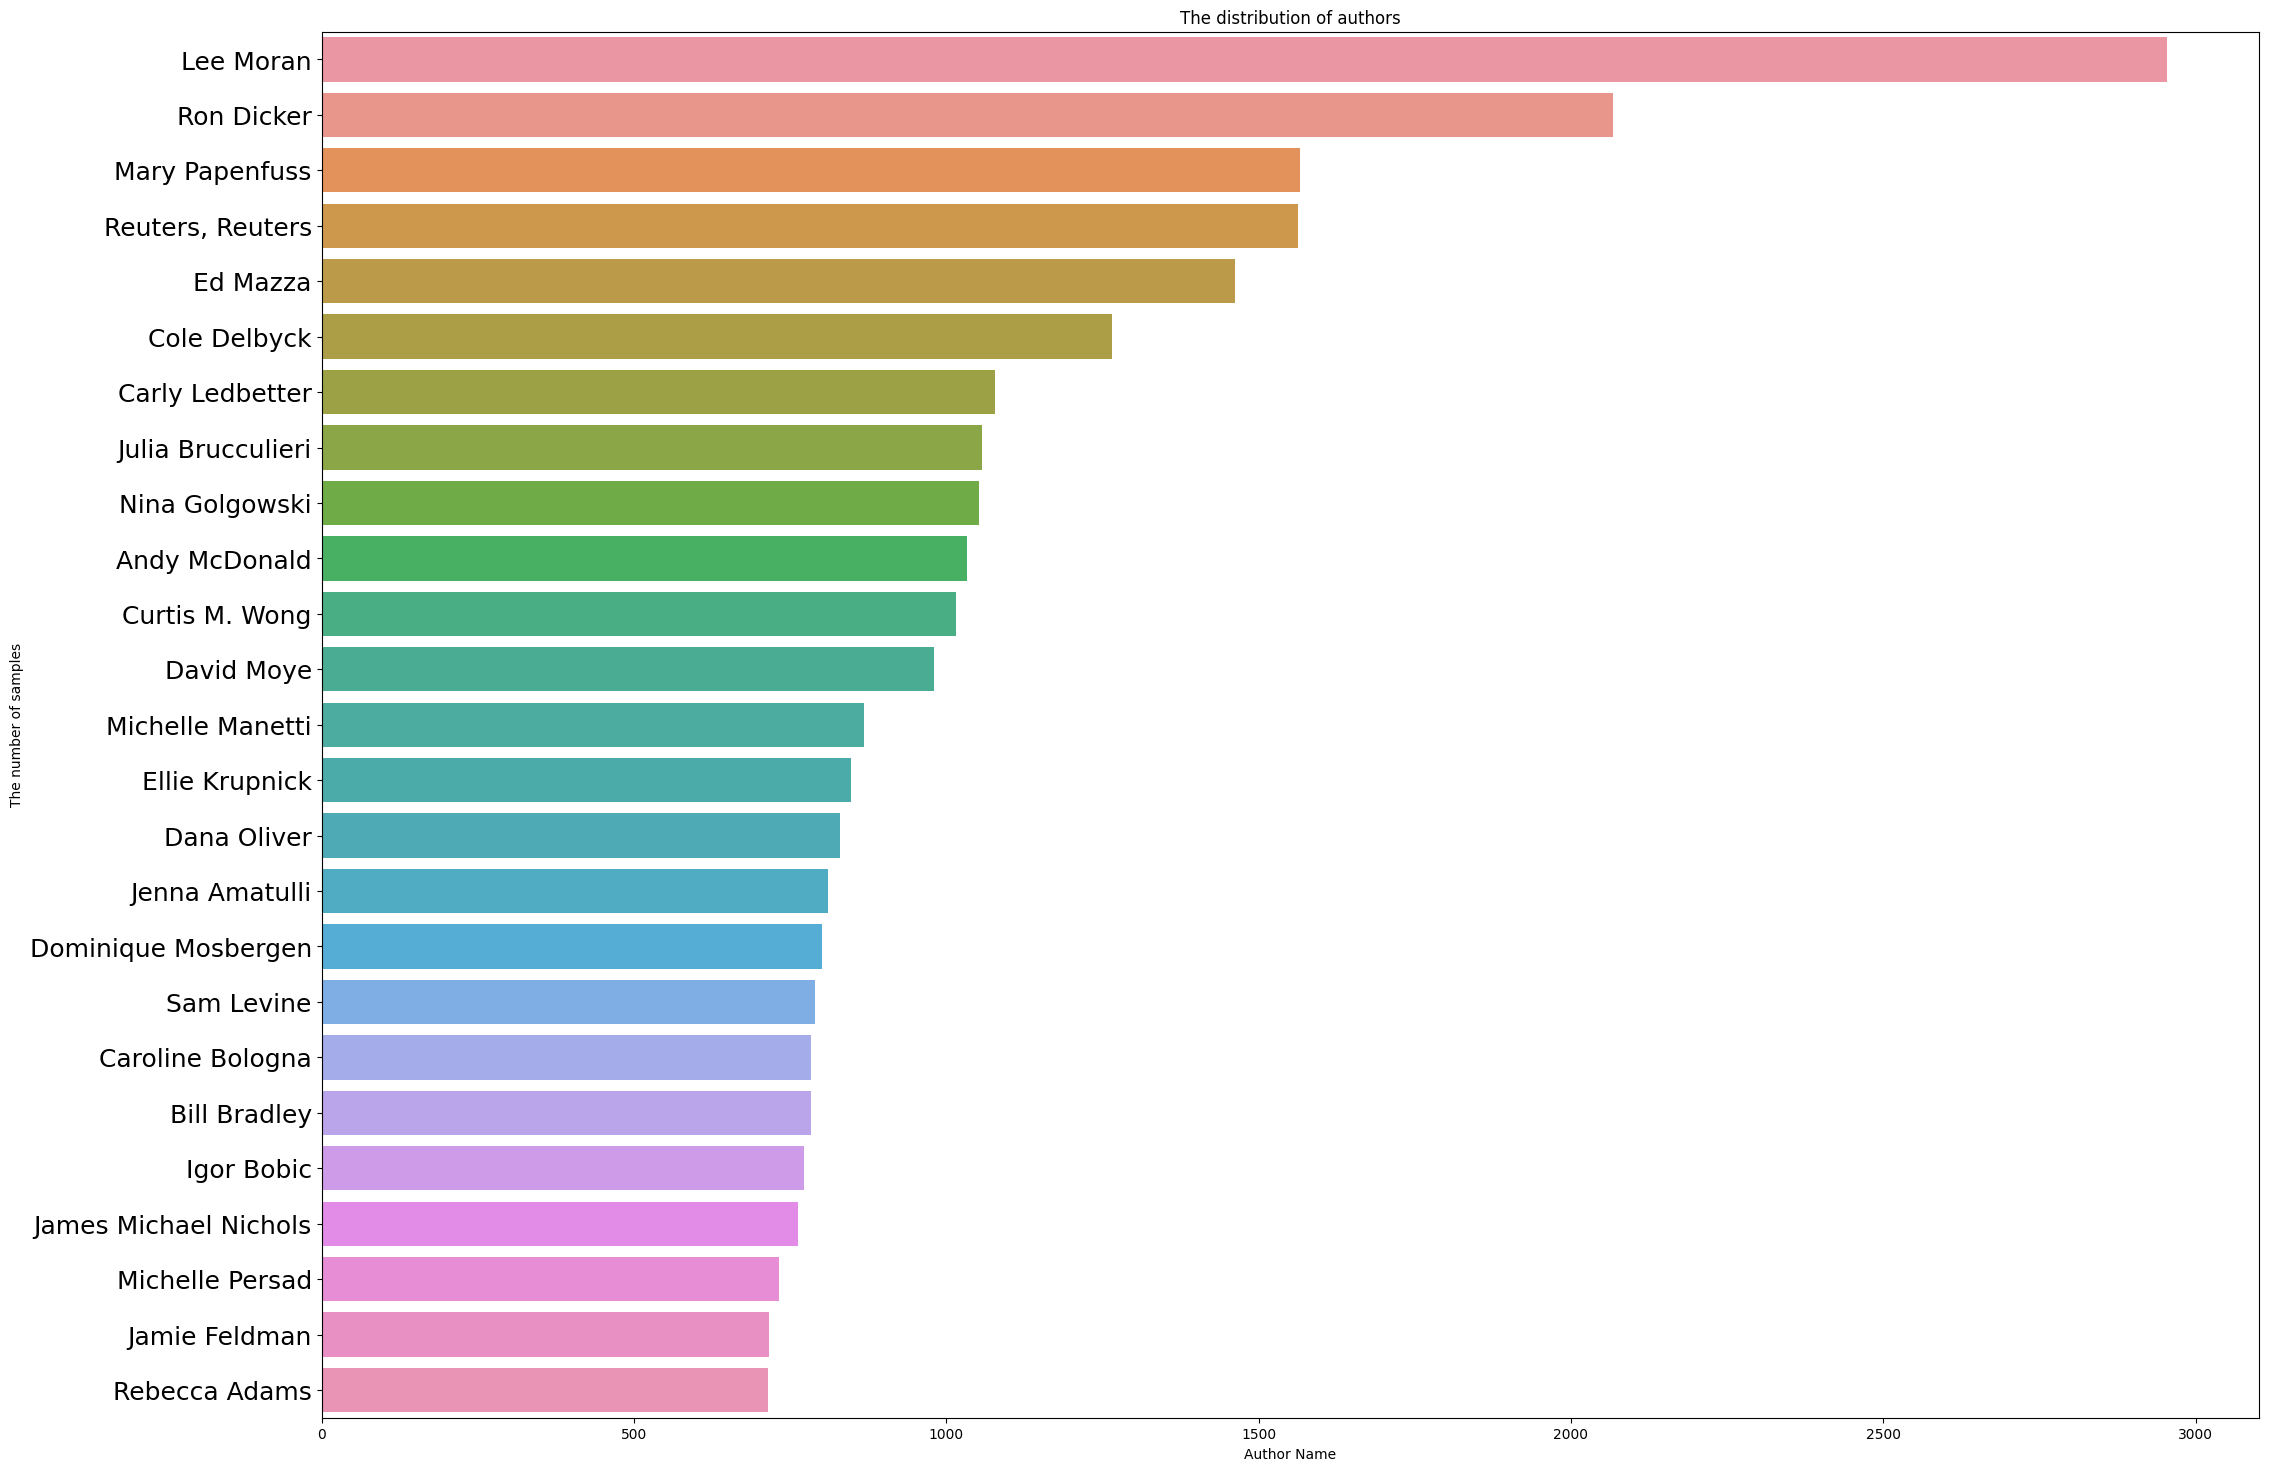

<Figure size 640x480 with 0 Axes>

In [121]:
#author
#auhtor plot
auhtor_count = data['authors'].value_counts()

plt.figure(figsize=(25,18))
sns.barplot(y=auhtor_count[:25].index,x=auhtor_count[:25].values)
plt.title("The distribution of authors")
plt.xlabel("Author Name")
plt.ylabel("The number of samples")

plt.yticks(rotation=0,fontsize = 18)
plt.show()
plt.savefig(r"./author_bar.png")

#### Balance the category data

In [122]:
category = data['category'].value_counts()
list(category.index)

['POLITICS',
 'ENTERTAINMENT',
 'WELLNESS',
 'TRAVEL',
 'STYLE & BEAUTY',
 'PARENTING',
 'HEALTHY LIVING',
 'QUEER VOICES',
 'FOOD & DRINK',
 'BUSINESS',
 'COMEDY',
 'SPORTS',
 'HOME & LIVING',
 'PARENTS',
 'BLACK VOICES',
 'IMPACT',
 'WOMEN',
 'WORLD NEWS',
 'THE WORLDPOST',
 'MEDIA',
 'CRIME',
 'WEIRD NEWS',
 'TASTE',
 'RELIGION',
 'WEDDINGS',
 'DIVORCE',
 'GREEN',
 'TECH',
 'MONEY',
 'STYLE',
 'SCIENCE',
 'ARTS & CULTURE',
 'WORLDPOST',
 'U.S. NEWS',
 'FIFTY',
 'GOOD NEWS',
 'EDUCATION',
 'LATINO VOICES',
 'ARTS',
 'COLLEGE',
 'ENVIRONMENT',
 'CULTURE & ARTS']


we can drop the Style, Education, College and Environment they are having very less number of sample, which may lead to less accuracy and f1 score.

In [123]:
cateo_keep = (data['category'] == 'POLITICS') | (data['category'] == 'WELLNESS' )| (data['category'] == 'ENTERTAINMENT') | (data['category'] == 'TRAVEL') | \
            (data['category'] == 'STYLE & BEAUTY') | (data['category'] == 'PARENTING' )| (data['category'] == 'HEALTHY LIVING') | (data['category'] == 'QUEER VOICES') | \
              (data['category'] == 'FOOD & DRINK') | (data['category'] == 'BUSINESS' )| (data['category'] == 'COMEDY') | (data['category'] == 'PARENTS') | (data['category'] == 'SPORTS') | (data['category'] == 'HOME & LIVING' )| (data['category'] == 'BLACK VOICES')
data = data[cateo_keep]



In [124]:
category = data['category'].value_counts()
category

POLITICS          29673
ENTERTAINMENT     13461
WELLNESS          12944
TRAVEL             8021
STYLE & BEAUTY     7173
PARENTING          6517
HEALTHY LIVING     5071
QUEER VOICES       4699
FOOD & DRINK       4527
BUSINESS           4372
COMEDY             3934
SPORTS             3608
HOME & LIVING      3490
PARENTS            3451
BLACK VOICES       3310
Name: category, dtype: int64

In [125]:
from sklearn.utils import resample

In [126]:
data_1 = data[data['category'] == 'POLITICS']
data_1 = resample(data_1, replace=False, n_samples=3000, random_state=123)
data_2 = data[data['category'] == 'WELLNESS']
data_2 = resample(data_2, replace=False, n_samples=3000, random_state=123)
data_3 = data[data['category'] == 'ENTERTAINMENT']
data_3 = resample(data_3, replace=False, n_samples=3000, random_state=123)
data_4 = data[data['category'] == 'TRAVEL']
data_4 = resample(data_4, replace=False, n_samples=3000, random_state=123)
data_5 = data[data['category'] == 'STYLE & BEAUTY']
data_5 = resample(data_5, replace=False, n_samples=3000, random_state=123)
data_6 = data[data['category'] == 'PARENTING']
data_6 = resample(data_6, replace=False, n_samples=3000, random_state=123)
data_7 = data[data['category'] == 'HEALTHY LIVING']
data_7 = resample(data_7, replace=False, n_samples=3000, random_state=123)
data_8 = data[data['category'] == 'QUEER VOICES']
data_8 = resample(data_8, replace=False, n_samples=3000, random_state=123)
data_9 = data[data['category'] == 'FOOD & DRINK']
data_9 = resample(data_9, replace=False, n_samples=3000, random_state=123)
data_10 = data[data['category'] == 'BUSINESS']
data_10 = resample(data_10, replace=False, n_samples=3000, random_state=123)
data_11 = data[data['category'] == 'COMEDY']
data_11 = resample(data_11, replace=False, n_samples=3000, random_state=123)
data_12= data[data['category'] == 'PARENTS']
data_12 = resample(data_12, replace=False, n_samples=3000, random_state=123)
data_13= data[data['category'] == 'SPORTS']
data_13 = resample(data_13, replace=False, n_samples=3000, random_state=123)
data_14 = data[data['category'] == 'HOME & LIVING']
data_14 = resample(data_14, replace=False, n_samples=3000, random_state=123)
data_15 = data[data['category'] == 'BLACK VOICES']
data_15 = resample(data_15, replace=False, n_samples=3000, random_state=123)

cato_list = [data_1 , data_2 , data_3 , data_4 ,data_5 , data_6, data_7, data_8 , data_9 , data_10, data_11 , data_12 , data_13, data_14 ,data_15]
#  data_7, data_8 , data_9 , data_10, data_11 , data_12 , data_13, data_14 ,data_15
data = pd.concat(cato_list)
data['category'].value_counts()

POLITICS          3000
WELLNESS          3000
ENTERTAINMENT     3000
TRAVEL            3000
STYLE & BEAUTY    3000
PARENTING         3000
HEALTHY LIVING    3000
QUEER VOICES      3000
FOOD & DRINK      3000
BUSINESS          3000
COMEDY            3000
PARENTS           3000
SPORTS            3000
HOME & LIVING     3000
BLACK VOICES      3000
Name: category, dtype: int64

#### Column Combinning

In [127]:
data['text'] = data['headline']+' '+data['short_description']

In [128]:
#drop the other columns
data.drop(['authors','headline','short_description'],axis=1,inplace=True)

In [129]:
from sklearn.utils import shuffle
data = shuffle(data)
data.reset_index(inplace=True, drop=True)

#### test cleaning

In [130]:
"""corpus=[]
for i in range(100000):
    text = data.iloc[i,1]

    text = text.lower()
    text = re.sub('[^a-z0-9]',' ',text)
    text = text.split()

    s = PorterStemmer()
    text = [s.stem(word) for word in text if not word in set(stopwords.words('english')) ]
    text = ' '.join(text)
    corpus.append(text)

    if i%1000==0:
        print(i,end='->')"""


"corpus=[]\nfor i in range(100000):\n    text = data.iloc[i,1]\n\n    text = text.lower()\n    text = re.sub('[^a-z0-9]',' ',text)\n    text = text.split()\n\n    s = PorterStemmer()\n    text = [s.stem(word) for word in text if not word in set(stopwords.words('english')) ]\n    text = ' '.join(text)\n    corpus.append(text)\n\n    if i%1000==0:\n        print(i,end='->')"

In [131]:
"""corpus = pd.read_csv('../input/corpus/corpus.csv')
corpus"""

"corpus = pd.read_csv('../input/corpus/corpus.csv')\ncorpus"

#### Tokazitation and Count Vectorization

In [132]:
labels.shape

(45000, 15)

In [133]:
#train and test split
tok.fit_on_texts(data['text'])
sequence = tok.texts_to_sequences(data['text'])
max_len = 30
data['word_seq'] = sequence
df = pad_sequences(data['word_seq'], maxlen=max_len)

In [134]:
encoder.fit(data['category'])
labels = encoder.transform(data['category'])
n_classes = max(labels) + 1
labels = to_categorical(labels, n_classes)

In [135]:
encoder.inverse_transform(np.asarray(range(15)))
# encoder.inverse_transform(np.asarray(range(6)))

array(['BLACK VOICES', 'BUSINESS', 'COMEDY', 'ENTERTAINMENT',
       'FOOD & DRINK', 'HEALTHY LIVING'], dtype=object)

In [136]:
X_TRAIN,X_TEST,Y_TRAIN,Y_TEST = train_test_split(df, labels ,test_size = 0.25, random_state=2)

In [137]:
X_TRAIN,X_VAL,Y_TRAIN,Y_VAL = train_test_split(X_TRAIN, Y_TRAIN ,test_size = 0.25,random_state=2)

In [138]:
print("The X_train shape----->",X_TRAIN.shape)
print('The X_text shape------>',X_TEST.shape)
print("THe y_train shape----->",Y_TRAIN.shape)
print("The y_test shape------>",Y_TEST.shape)

The X_train shape-----> (25312, 30)
The X_text shape------> (11250, 30)
THe y_train shape-----> (25312, 15)
The y_test shape------> (11250, 15)


In [139]:
optimizer = 'Adam'
TRAIN_DATA = (X_TRAIN, Y_TRAIN)
VAL_DATA = (X_VAL, Y_VAL)

In [140]:
losses = [tf.keras.losses.CategoricalCrossentropy(), FocalLoss()]
for loss in losses:
  models = [ANNModel(n_classes=15), ANNDropout(n_classes=15, dropout_rate=0.3), ANNDropout2(n_classes=15, dropout_rate=0.3)]
  # models = [ANNModel(n_classes=6), ANNDropout(n_classes=6, dropout_rate=0.3), ANNDropout2(n_classes=6, dropout_rate=0.3)]
  for model in models:
    train(model, TRAIN_DATA, VAL_DATA, loss, optimizer, METRICS, epochs=20)
    test(model, X_TEST, Y_TEST)

Epoch 1/20
198/198 [==============================] - 3s 12ms/step - loss: 2.9370 - categorical_accuracy: 0.1836 - val_loss: 2.5594 - val_categorical_accuracy: 0.1413
Epoch 2/20
198/198 [==============================] - 2s 10ms/step - loss: 2.4123 - categorical_accuracy: 0.1711 - val_loss: 2.3440 - val_categorical_accuracy: 0.2050
Epoch 3/20
198/198 [==============================] - 2s 11ms/step - loss: 2.1857 - categorical_accuracy: 0.2610 - val_loss: 2.1968 - val_categorical_accuracy: 0.2783
Epoch 4/20
198/198 [==============================] - 2s 12ms/step - loss: 1.9480 - categorical_accuracy: 0.3763 - val_loss: 2.1732 - val_categorical_accuracy: 0.3192
Epoch 5/20
198/198 [==============================] - 3s 16ms/step - loss: 1.7498 - categorical_accuracy: 0.4693 - val_loss: 2.2497 - val_categorical_accuracy: 0.3357
Epoch 6/20
198/198 [==============================] - 4s 22ms/step - loss: 1.5542 - categorical_accuracy: 0.5645 - val_loss: 2.4122 - val_categorical_accuracy: 0.341

train_accuracy,▁▂▄▅▆▆▇▇▇▇▇▇████████
train_loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▆▇▇▇▇▇████████████
val_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.9117
train_loss,0.24976
val_accuracy,0.70963
val_loss,0.58114


88/88 [==============================] - 1s 8ms/step
For each class: 
Accuracy:  tensor([0.3215, 0.2335, 0.2757, 0.2474, 0.3824, 0.2686, 0.4946, 0.1863, 0.2177,
        0.3484, 0.3601, 0.3375, 0.3905, 0.2136, 0.1804, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000])
Precision:  tensor([0.1857, 0.2574, 0.5425, 0.2006, 0.4899, 0.1505, 0.5155, 0.2439, 0.1264,
        0.4501, 0.5672, 0.3793, 0.6296, 0.2010, 0.2911, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000])
Recall:  tensor([0.3215, 0.2335, 0.2757, 0.2474, 0.3824, 0.2686, 0.4946, 0.1863, 0.2177,
        0.3484, 0.3601, 0.3375, 0.3905, 0.2136, 0.1804, 0.0000, 0.0000, 0.0000,
        0.0000, 

train_accuracy,▁▁▂▃▄▄▅▆▇▇██████████
train_loss,█▇▆▅▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▃▆▇████▇▇▇▇▇▇▇▇▇▇▇▇
val_loss,▂▁▁▁▁▂▂▃▄▅▅▆▆▇▇▇████
train_accuracy,0.99862
train_loss,0.35267
val_accuracy,0.30754
val_loss,4.62097


88/88 [==============================] - 0s 2ms/step
For each class: 
Accuracy:  tensor([0.3038, 0.2389, 0.3253, 0.2742, 0.4179, 0.2141, 0.5311, 0.1836, 0.1956,
        0.4067, 0.3463, 0.4105, 0.3932, 0.2438, 0.2300, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000])
Precision:  tensor([0.1874, 0.2950, 0.5553, 0.2085, 0.4775, 0.1398, 0.5032, 0.2442, 0.1496,
        0.4457, 0.5111, 0.4203, 0.6799, 0.2067, 0.2774, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000])
Recall:  tensor([0.3038, 0.2389, 0.3253, 0.2742, 0.4179, 0.2141, 0.5311, 0.1836, 0.1956,
        0.4067, 0.3463, 0.4105, 0.3932, 0.2438, 0.2300, 0.0000, 0.0000, 0.0000,
        0.0000, 

train_accuracy,▁▁▂▂▃▄▅▅▆▆▇▇▇▇██████
train_loss,█▇▆▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▃▅▇██████████▇█▇▇▇▇
val_loss,▂▂▁▁▁▁▂▂▃▄▄▅▅▆▆▇▇▇██
train_accuracy,0.92841
train_loss,0.63696
val_accuracy,0.31097
val_loss,4.72813


88/88 [==============================] - 0s 2ms/step
For each class: 
Accuracy:  tensor([0.2847, 0.2416, 0.2554, 0.2781, 0.4231, 0.2314, 0.5527, 0.2145, 0.2282,
        0.3994, 0.3940, 0.4063, 0.3973, 0.1940, 0.1736, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000])
Precision:  tensor([0.2043, 0.2111, 0.4277, 0.2430, 0.4460, 0.1413, 0.4846, 0.2540, 0.1432,
        0.4544, 0.6181, 0.4525, 0.6519, 0.2067, 0.2910, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000])
Recall:  tensor([0.2847, 0.2416, 0.2554, 0.2781, 0.4231, 0.2314, 0.5527, 0.2145, 0.2282,
        0.3994, 0.3940, 0.4063, 0.3973, 0.1940, 0.1736, 0.0000, 0.0000, 0.0000,
        0.0000, 

train_accuracy,▁▁▁▂▃▃▄▅▅▅▆▆▇▇▇▇████
train_loss,█▆▆▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁
val_accuracy,▁▄▄▅▇▇█▇████████████
val_loss,▂▁▁▁▁▁▁▂▂▃▃▄▅▅▆▆▇▇██
train_accuracy,0.84482
train_loss,0.84004
val_accuracy,0.30718
val_loss,4.45818


88/88 [==============================] - 1s 7ms/step
For each class: 
Accuracy:  tensor([0.5123, 0.4548, 0.4358, 0.4872, 0.6505, 0.3138, 0.6905, 0.4692, 0.4159,
        0.6108, 0.5558, 0.6006, 0.6378, 0.5505, 0.3939, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000])
Precision:  tensor([0.3833, 0.4120, 0.6423, 0.3778, 0.7258, 0.3734, 0.6518, 0.4122, 0.3997,
        0.6329, 0.6179, 0.6220, 0.7375, 0.5915, 0.3912, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000])
Recall:  tensor([0.5123, 0.4548, 0.4358, 0.4872, 0.6505, 0.3138, 0.6905, 0.4692, 0.4159,
        0.6108, 0.5558, 0.6006, 0.6378, 0.5505, 0.3939, 0.0000, 0.0000, 0.0000,
        0.0000, 

train_accuracy,▁▃▅▆▆▆▇▇▇▇▇▇▇███████
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▆▇▇▇██████████████
val_loss,█▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.90107
train_loss,0.77557
val_accuracy,0.51315
val_loss,6.2554


88/88 [==============================] - 1s 6ms/step
For each class: 
Accuracy:  tensor([0.4237, 0.4845, 0.4752, 0.4005, 0.6491, 0.3644, 0.6797, 0.4960, 0.4302,
        0.6137, 0.5797, 0.6708, 0.6189, 0.4522, 0.3526, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000])
Precision:  tensor([0.4449, 0.4141, 0.6585, 0.4015, 0.6595, 0.3142, 0.6202, 0.4167, 0.4204,
        0.6331, 0.6252, 0.5578, 0.6971, 0.5259, 0.4006, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000])
Recall:  tensor([0.4237, 0.4845, 0.4752, 0.4005, 0.6491, 0.3644, 0.6797, 0.4960, 0.4302,
        0.6137, 0.5797, 0.6708, 0.6189, 0.4522, 0.3526, 0.0000, 0.0000, 0.0000,
        0.0000, 

train_accuracy,▁▂▄▅▆▆▆▇▇▇▇▇▇███████
train_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▆▇▇███████████████
val_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.85619
train_loss,0.96169
val_accuracy,0.50273
val_loss,7.32593


88/88 [==============================] - 0s 4ms/step
For each class: 
Accuracy:  tensor([0.4946, 0.4602, 0.5019, 0.3431, 0.6912, 0.3830, 0.7000, 0.3968, 0.4459,
        0.6050, 0.5935, 0.6281, 0.6730, 0.5439, 0.3719, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000])
Precision:  tensor([0.4454, 0.4710, 0.5418, 0.4250, 0.6858, 0.3578, 0.6599, 0.4554, 0.4111,
        0.5764, 0.6095, 0.6247, 0.6813, 0.5341, 0.3479, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000])
Recall:  tensor([0.4946, 0.4602, 0.5019, 0.3431, 0.6912, 0.3830, 0.7000, 0.3968, 0.4459,
        0.6050, 0.5935, 0.6281, 0.6730, 0.5439, 0.3719, 0.0000, 0.0000, 0.0000,
        0.0000, 